# Improving state prep errors on IBM Quantum systems

```{post} 2021-11-07
:tags: SPAM, Reset, Dynamic
:category: Hardware
```

It is often taken for granted that qubits are initialized to zero when executing quantum circuits on hardware.  However, errors in the reset process mean that this initialization is not perfect leading to state preparation errors.  Here we will look at state prep errors and how to improve them on IBM Quantum systems.

Here we will use two lesser known configuration variables available on IBM Quantum systems to do so.  First is `rep_delay`.  This is the delay time before the next circuit is executed.  Each backend has a different `default_rep_delay` (although as of the time of writing many are $250~\mu \rm s$ or lower) and support tuning this parameter from $0$ up to $500~\mu \rm s$.  Why in the world would I want to vary this parameter?  Well if I set `rep_delay=0` then I can get much faster throughput as the default delay is nominally longer than the $T_{1}$ time of the system.  However when doing so you are trusting the implicit reset (called "unconditional reset") to do its job and reset the qubits to their ground state with high-fidelity.  Failure to do so would lead to state-prep errors that propagate through the circuit.  This is why the delay is usually longer than $T_{1}$; let the enviornment help your reset fidelity.  Second is `init_qubits` that tells the hardware to not perform an unconditional reset.  As no reset at all would quickly lead to junk, this setting needs to be done in concert with `reset` instructions being added to the beginning of your circuits.  Perhaps this is better, or maybe a single reset at the beginning and the uncondtional reset.  Lets find out.

## Summary

It is possible to vary the delay time between circuits using `rep_delay` and to turn off the implict reset done on IBM Quantum systems using `init_qubits=False`.  In the latter case, qubit initialization needs to be done using one or more `reset` instructions.  By looking a SPAM errors as we vary `rep_delay` we can see when state prep errors being to get worse.  This is quite apparent on some systems but not others.

To reduce state prep errors one can try increasing the `rep_delay`.  Occasionally this is needed, and going up to $~400~\mu \rm s$ is not unheard of to try and get maximum fidelity results.  In addition, or alternatively, it is in general beneficial to add a single `reset` to the beginning of a circuit (after a barrier since Qiskit will remove it otherwise).  On some systems we can use multiple resets in combination with `init_qubits=False` to get better error rates and simultaneously allow for increasing throughput through smaller (possibly zero) `rep_delay`.

These features give users yet another knob to try to maximize the fidelty of their circuits, but require a fair bit of exploration and experimentation in order to get it right.}

## Average SPAM error rate per qubit 

To understand what effect the above mentioned variables have on the performance of our system we must first find a way to compute state preperation and measurement (SPAM) errors.  To do so we will assume that we want to look at the error rate for prepping and measuring a state in the computational basis.  Here we will use the all-zeros and all-ones states where each qubit undergoes the same operations.  We can ask ourselves that, given that we know the target state we want to prep, what is the average Hamming distance of our samples from the target bit string.  In formula this reads:

$$
\bar{H} = \sum_{k=1}^{N_{Q}} k \left({N_{Q} \atop {k}}\right) p^{k}(1-p)^{N_{Q}-k}
$$

where $\bar{H}$ is the average Hamming distance from our data, $N_{Q}$ is the number of qubits, and $p$ is the average error per qubit that we seek.

Solving for $p$ involves solving for the roots of the above polynomial such that $p \in[0,1]$.  Although it is possible to have multiple roots in this domain, if we consider the smallest root to be the physical one then it turns out that the solution $p$ we want can be defined in terms of the *Hamming fraction*:

$$
p = H_{\rm frac} \equiv \frac{\bar{H}}{N_{Q}}
$$

Thus it is quite easy to get the average error $p$ we are looking for directly by computing the average Hamming distance our data is away from the target bit string.

## Frontmatter

In [1]:
import numpy as np
from qiskit import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Define needed functions

In [2]:
def target_basis_circ(bitstring, with_reset=False):
    """Prep and measure target computational basis state.
    
    Parameters:
        bitstring (str): The target basis state
        with_reset (bool or int): Use a reset at beginning, default=False.
        
    Returns:
        QuantumCircuit: Circuit.
    """
    with_reset = int(with_reset)
    num_qubits = len(bitstring)
    qc = QuantumCircuit(num_qubits)
    qc.barrier()
    if with_reset:
        for jj in range(with_reset):
            qc.reset(range(num_qubits))
    for kk in range(num_qubits):
        if bitstring[kk] == '1':
            qc.x(num_qubits-1-kk)
    qc.measure_all()
    return qc

In [3]:
def hamming_distance(str1, str2):
    """Hamming distance between two bit strings.
    
    Parameters:
        str1 (str): Bit string 1.
        str2 (str): Bit string 2.
        
    Returns:
        int: Hamming distance.
    """
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

In [4]:
def hamming_fraction(counts, target_state):
    """Hamming fraction of counts data from target state.
    
    Parameters:
        counts (Counts): Counts data.
        target_state (str): Target bit string state
        
    Returns:
        float: Hamming fraction.
    """
    num_shots = sum(counts.values())
    num_qubits = len(target_state)

    avg_hamming_dist = 0
    for key, val in counts.items():
        ham_dist = hamming_distance(key, target_state)
        avg_hamming_dist += ham_dist*(val/num_shots)

    return avg_hamming_dist/num_qubits

## Experiments

Here we measure the SPAM error rate per qubit for the all-zeros and all-ones states as a function of `rep_delay` and also explore the use of `resets` and the `init_qubits` functionality.  We expect these two states to be different as the all-ones state is affected by $T_{1}$ whereas th all-zeros state is weakly affected by thermal excitations.  What we a priori do not know is how a change in `rep_delay` changes the per qubit SPAM error rate, nor how does the use of `reset` operations changes anything.  Things are also likely system specific so we just need to explore.

### Effect of `rep_delay` on state prep error

To begin let us look at a good example of how varying the `rep_delay` can affect the error rate of our system.  Here we will look at some data taken with the above routines on the `ibmq_montreal` system which is a 27Q Falcon R4 device.  Since not everyone has access to this system I will just show the data.

In [11]:
rep_range = np.linspace(0, 500e-6, 21)
default_rep_delay = 50e-6

mon_p0 = np.array([0.01859538, 0.01435456, 0.01327854, 0.01304344, 0.01346842,
                   0.01193576, 0.01227485, 0.01321976, 0.01191768, 0.01208044,
                   0.01304796, 0.0121573 , 0.01279026, 0.01174136, 0.01214374,
                   0.0123065 , 0.01269983, 0.01199454, 0.01240596, 0.01259585,
                   0.01262297])

mon_p1 = np.array([0.03958243, 0.03575304, 0.03152579, 0.0313359 , 0.03016493,
                   0.02918837, 0.0288538 , 0.02802192, 0.02780038, 0.02611853,
                   0.02565737, 0.02574779, 0.02615469, 0.02652543, 0.02592864,
                   0.02576588, 0.0268193 , 0.02578848, 0.02498825, 0.0264124 ,
                   0.02582917])

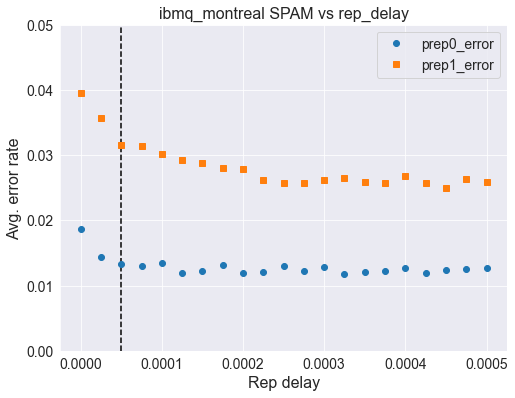

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, mon_p0, 'o',label='prep0_error')
ax.plot(rep_range, mon_p1, 's', label='prep1_error')
ax.legend(fontsize=14)
ax.set_ylim([0,0.05])
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay'.format('ibmq_montreal'), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Montreal is the system with the fastest `default_rep_delay` at $50~\mu \rm s$ (vertical dashed line).  Above we see a very clear rise in error rates as the `rep_delay` increases indicating state prep errors starting to creep in.  For those users trying to maximize the fidelity of results, going up to something around $200~\mu \rm s$ for `rep_delay` is likely a good thing to do here.

### 5Q Manila system

Here I pick the `ibmq_manila` system as no one else is on it at the moment and it is a public system.  It is a 5Q system based on the Falcon 5.11 processor revison.

In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = IBMQ.get_provider(project='internal-test')

In [24]:
backend = provider.backend.ibmq_manila
num_qubits = backend.configuration().num_qubits
max_shots = backend.configuration().max_shots

Let us check the default `rep_delay` and `rep_delay_range` on this system:

In [16]:
default_rep_delay = backend.configuration().default_rep_delay
rep_delay_range = backend.configuration().rep_delay_range

print('Default rep delay = {} us'.format(default_rep_delay*1e6))
print('rep delay range : [{}, {}] us'.format(rep_delay_range[0],
                                             rep_delay_range[1]*1e6))

Default rep delay = 250.0 us
rep delay range : [0.0, 500.0] us


In [25]:
rep_range = np.linspace(0, rep_delay_range[1], 11)
num_shots = min(10000, max_shots)

#### SPAM error rate with no resets

To begin we are going to reproduce the same plot as we did for Montreal by looping over `rep_range` and computing the Hamming fraction that is the error rate we are looking for.  Here we do not use `reset` instructions at the beginning.

In [106]:
prep0_errors = []
prep1_errors = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = False

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors.append(p_zeros)
    prep1_errors.append(p_ones)

Here we plot the data along with the `default_rep_delay` represented by the vertical dashed line.

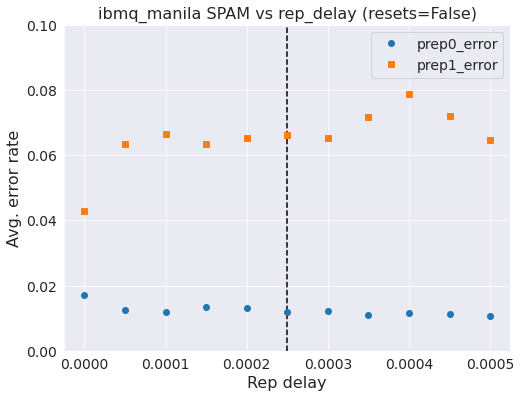

In [107]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors, 'o',label='prep0_error')
ax.plot(rep_range, prep1_errors, 's', label='prep1_error')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay (resets={})'.format(backend.name(),
                                                       use_resets), fontsize=16);

So we see that the all-ones state is hovering at about 6.5% error whilst the all-zeros state is around 1%.  The measurement error rate reported by the backend is 5% and 1.5%, respectively.  That data is taken at the `default_rep_delay`.  The all-ones data is a bit hard to interpret, but for the all-zeros state you can see a gradual increase in the error as we decrease `rep_delay`.  Not as clear cut a story as on Montreal, and the all-ones error is quite a bit higher (~2x).

#### SPAM error rate with resets

In the previous example you might have noticed that the error rates increase as one reduces the `rep_delay` (Then again maybe you didn't, we are doing research after all).  This is a sign that state prep errors are starting to creep in more.  We can try to prevent this by adding a reset to the beginning of our circuit.  If the measurement errors are low-enough (reset is a measurement followed by a conditional x-gate) then we should be able to suppress the state prep errors that are introduced at low `rep_delays`.  Note that when adding `reset` instructions to the front your circuit it is best to put a `barrier` before otherwise the Qiskit transpiler will remove them.

In [83]:
prep0_errors_reset = []
prep1_errors_reset = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = True

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors_reset.append(p_zeros)
    prep1_errors_reset.append(p_ones)

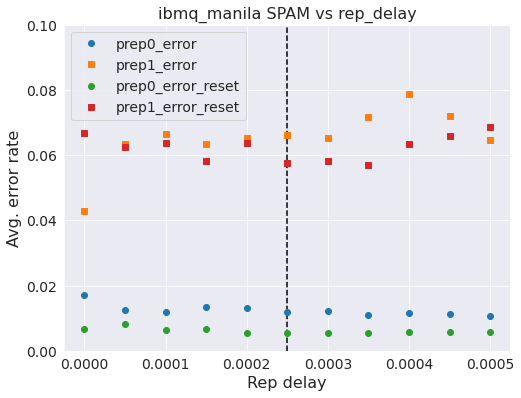

In [108]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors, 'o',label='prep0_error')
ax.plot(rep_range, prep1_errors, 's', label='prep1_error')
ax.plot(rep_range, prep0_errors_reset, 'o',label='prep0_error_reset')
ax.plot(rep_range, prep1_errors_reset, 's', label='prep1_error_reset')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay'.format(backend.name()), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In the above we do see that resets help here in giving you a ~0.5% decrease in the error rates.  We are still not seeing a clear trend when verying `rep_delay` but progress is being made.

#### SPAM error rate with reset and NO implicit reset

Just for fun, lets turn off implicit reset using `init_qubits=False` and see what the error rate looks like if we rely on a single reset alone for the state prep.

In [85]:
prep0_errors_fun = []
prep1_errors_fun = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = True

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay, init_qubits=False)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay, init_qubits=False)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors_fun.append(p_zeros)
    prep1_errors_fun.append(p_ones)

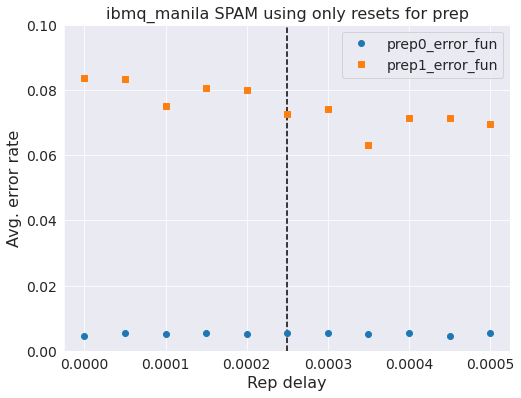

In [109]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors_fun, 'o',label='prep0_error_fun')
ax.plot(rep_range, prep1_errors_fun, 's', label='prep1_error_fun')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM using only resets for prep'.format(backend.name()), fontsize=16);

So now we see some interesting stuff.  Using only a single-reset for preping the qubits to the zeros state we see that the all-ones error is overall bigger and trends higher as we decrease `rep_delay`.  However, the error in the all-zeros state is much lower than before.

#### SPAM error rate using 3x resets

The above hints that maybe good things can happen if we used more resets at the beginning.  I say this because applying more than one reset should have things looking closer to the all-zeros state when it hits the later resets where we see some improvement.  Lets see what happens.

In [120]:
prep0_errors_fun3 = []
prep1_errors_fun3 = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = 3

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay, init_qubits=False)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay, init_qubits=False)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors_fun3.append(p_zeros)
    prep1_errors_fun3.append(p_ones)

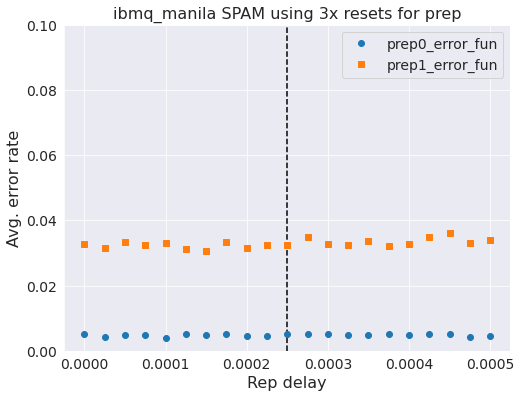

In [122]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors_fun3, 'o',label='prep0_error_fun')
ax.plot(rep_range, prep1_errors_fun3, 's', label='prep1_error_fun')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM using 3x resets for prep'.format(backend.name()), fontsize=16);

Oh man, we have decreased that error rate in the all-ones state by a factor of 2x AND it is independent of `rep_delay`.  That is to say **we have reduced the error rate and increased the throughput of our system since we can set `rep_delay=0`**.  This is cool but also a bit surprising as the reported readout error is 3.25% and we are seeing less than that and readout error also has state prep errors implicitly in there.

### 7Q Jakarta system

The Jakarta system is all the rage these days, e.g. see https://twitter.com/MJBiercuk/status/1456346789561335808 and https://twitter.com/blake_johnson/status/1456687596474671110.  Lets see if we can improve things on that Falcon 5.11 based system as well.

In [16]:
backend = provider.backend.ibmq_jakarta
num_qubits = backend.configuration().num_qubits

default_rep_delay = backend.configuration().default_rep_delay
rep_delay_range = backend.configuration().rep_delay_range

rep_range = np.linspace(0, rep_delay_range[1], 11)
num_shots = 10000

#### SPAM error rate

In [17]:
prep0_errors_jk = []
prep1_errors_jk = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = False

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors_jk.append(p_zeros)
    prep1_errors_jk.append(p_ones)

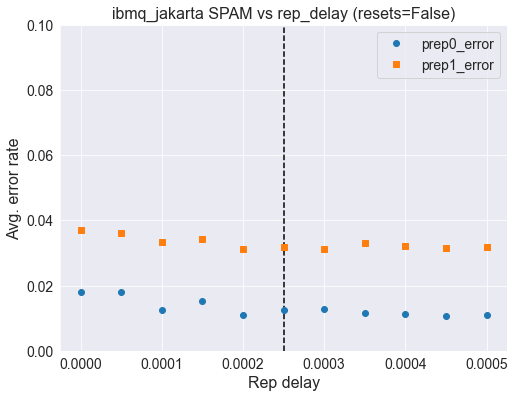

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors_jk, 'o',label='prep0_error')
ax.plot(rep_range, prep1_errors_jk, 's', label='prep1_error')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay (resets={})'.format(backend.name(),
                                                       use_resets), fontsize=16);

#### SPAM error rate using 3x resets

In [20]:
prep0_errors_jk3 = []
prep1_errors_jk3 = []

zeros_state = '0'*num_qubits
ones_state = '1'*num_qubits
use_resets = 3

for delay in rep_range:
    zeros_job = backend.run(target_basis_circ(zeros_state, use_resets),
                            shots=num_shots, rep_delay=delay, init_qubits=False)
    ones_job = backend.run(target_basis_circ(ones_state, use_resets),
                           shots=num_shots, rep_delay=delay, init_qubits=False)
    
    zeros_counts = zeros_job.result().get_counts()
    ones_counts = ones_job.result().get_counts()

    p_zeros = hamming_fraction(zeros_counts, zeros_state)
    p_ones = hamming_fraction(ones_counts, ones_state)
    
    prep0_errors_jk3.append(p_zeros)
    prep1_errors_jk3.append(p_ones)

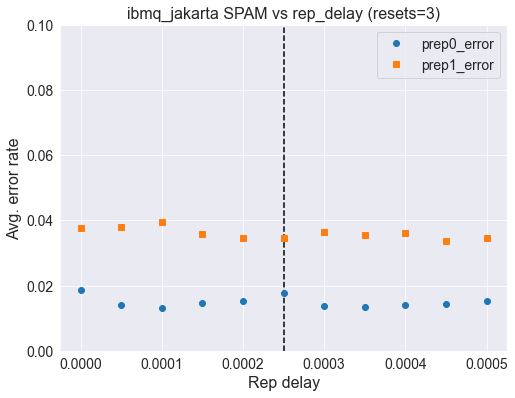

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, prep0_errors_jk3, 'o',label='prep0_error')
ax.plot(rep_range, prep1_errors_jk3, 's', label='prep1_error')
ax.legend(fontsize=14)
ax.set_ylim([0,0.1])
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay (resets={})'.format(backend.name(),
                                                       use_resets), fontsize=16);

We see that life is not easy.  On Jakarata, going to 3x resets does not improve things.  Instead it makes all the error rates slightly worse.  This is why the 3x `reset` is not default; most systems still work best with unconditional reset.  Exploring other systems one finds similar findings.

## Data for other systems

Here we show some data for other systems with and without a `reset` at the beginning but all using unconditional reset.  Overall we see that a `reset` at the beginning offers improved error rates.

In [24]:
rep_range = np.linspace(0, 500e-6, 21)

### Montreal

In [23]:
default_rep_delay = 50e-6

mon_p0 = np.array([0.01859538, 0.01435456, 0.01327854, 0.01304344, 0.01346842,
                   0.01193576, 0.01227485, 0.01321976, 0.01191768, 0.01208044,
                   0.01304796, 0.0121573 , 0.01279026, 0.01174136, 0.01214374,
                   0.0123065 , 0.01269983, 0.01199454, 0.01240596, 0.01259585,
                   0.01262297])

mon_p1 = np.array([0.03958243, 0.03575304, 0.03152579, 0.0313359 , 0.03016493,
                   0.02918837, 0.0288538 , 0.02802192, 0.02780038, 0.02611853,
                   0.02565737, 0.02574779, 0.02615469, 0.02652543, 0.02592864,
                   0.02576588, 0.0268193 , 0.02578848, 0.02498825, 0.0264124 ,
                   0.02582917])

mon_p0_reset = np.array([0.02195909, 0.01358597, 0.01205331, 0.01309317, 0.01126212,
                         0.012736  , 0.0123065 , 0.01159668, 0.01090947, 0.01222059,
                         0.01159668, 0.01186343, 0.01151982, 0.01211209, 0.01220251,
                         0.01299823, 0.01171423, 0.01250995, 0.01260489, 0.01670103,
                         0.01185438])

mon_p1_reset = np.array([0.03072555, 0.02814851, 0.02775517, 0.02593768, 0.02627224,
                         0.02506058, 0.0269052 , 0.02725333, 0.02639431, 0.02749747,
                         0.02656612, 0.02648926, 0.02685095, 0.02152054, 0.02158836,
                         0.02160645, 0.02177373, 0.02202239, 0.02124476, 0.0212764 ,
                         0.0215748 ])

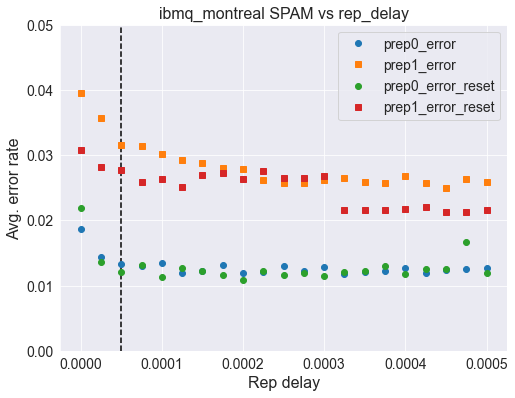

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, mon_p0, 'o',label='prep0_error')
ax.plot(rep_range, mon_p1, 's', label='prep1_error')
ax.plot(rep_range, mon_p0_reset, 'o',label='prep0_error_reset')
ax.plot(rep_range, mon_p1_reset, 's', label='prep1_error_reset')
ax.legend(fontsize=14)
ax.set_ylim([0,0.05])
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay'.format('ibmq_montreal'), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Hanoi

In [27]:
default_rep_delay = 250e-6

In [28]:
han_p0 = np.array([0.02571615, 0.02364999, 0.0232024 , 0.02805809, 0.02027724,
                   0.01981156, 0.01975279, 0.02103226, 0.02319788, 0.02500633,
                   0.02836552, 0.02222584, 0.02804   , 0.02224392, 0.01893446,
                   0.02032697, 0.01955838, 0.02504702, 0.0303503 , 0.01884856,
                   0.01970757])

han_p1 = np.array([0.04134567, 0.02829771, 0.02776874, 0.02464012, 0.02676957,
                   0.02323857, 0.02190032, 0.02336064, 0.02458587, 0.02843334,
                   0.02278194, 0.0234375 , 0.0245723 , 0.01984321, 0.0202908 ,
                   0.02269604, 0.02164261, 0.02235243, 0.0218099 , 0.01967593,
                   0.02084238])

han_p0_reset = np.array([0.01406069, 0.01524523, 0.01619014, 0.01575611, 0.01321524,
                         0.014662  , 0.016909  , 0.01762334, 0.01737015, 0.01768663,
                         0.01373517, 0.01681858, 0.01458514, 0.01574255, 0.01363118,
                         0.01548485, 0.01806641, 0.02033601, 0.01825177, 0.0141059 ,
                         0.01436813])

han_p1_reset = np.array([0.02414732, 0.02224392, 0.01856373, 0.01732946, 0.01853208,
                         0.02104583, 0.01800311, 0.01953577, 0.01612232, 0.02009639,
                         0.01692256, 0.016267  , 0.0181297 , 0.01756004, 0.01476147,
                         0.02139847, 0.01590079, 0.02293566, 0.01738824, 0.0153673 ,
                         0.02173756])

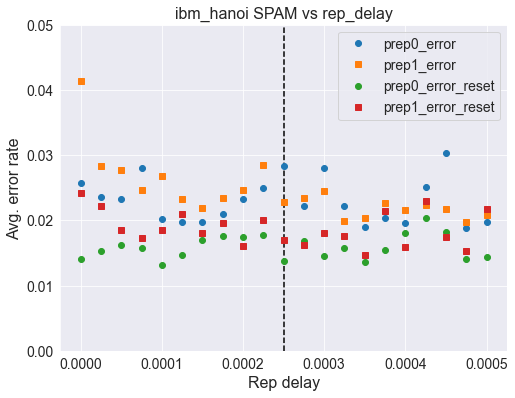

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, han_p0, 'o',label='prep0_error')
ax.plot(rep_range, han_p1, 's', label='prep1_error')
ax.plot(rep_range, han_p0_reset, 'o',label='prep0_error_reset')
ax.plot(rep_range, han_p1_reset, 's', label='prep1_error_reset')
ax.legend(fontsize=14)
ax.set_ylim([0,0.05])
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay'.format('ibm_hanoi'), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Perth

In [30]:
default_rep_delay = 250e-6

In [31]:
per_p0 = np.array([0.01656669, 0.01691546, 0.01621791, 0.01632254, 0.01703753,
                   0.01708984, 0.01771763, 0.01710728, 0.0171596 , 0.01956613,
                   0.01864188, 0.0212228 , 0.01794434, 0.01846749, 0.0183803 ,
                   0.01789202, 0.01787458, 0.02239118, 0.01893834, 0.01932199,
                   0.01776995])

per_p1 = np.array([0.02807617, 0.02748326, 0.02842494, 0.02622768, 0.02617536,
                   0.02645438, 0.02486747, 0.02638463, 0.02922712, 0.02889579,
                   0.02802386, 0.02934919, 0.03198242, 0.03259277, 0.02905273,
                   0.02870396, 0.03168597, 0.02751814, 0.02532087, 0.02511161,
                   0.02533831])

per_p0_reset = np.array([0.0144043 , 0.0150844 , 0.01532854, 0.01675851, 0.01766532,
                         0.01571219, 0.01473563, 0.01536342, 0.01595633, 0.01642718,
                         0.01599121, 0.01442174, 0.01459612, 0.0140904 , 0.01487514,
                         0.0140904 , 0.01438686, 0.01398577, 0.01290458, 0.01334054,
                         0.01447405])

per_p1_reset = np.array([0.02108329, 0.02169364, 0.02216448, 0.02361189, 0.02394322,
                         0.02521624, 0.02462333, 0.02594866, 0.02624512, 0.02553013,
                         0.0249721 , 0.02610561, 0.02657645, 0.02012416, 0.0213623 ,
                         0.02223424, 0.02239118, 0.02205985, 0.02251325, 0.02179827,
                         0.02319336])

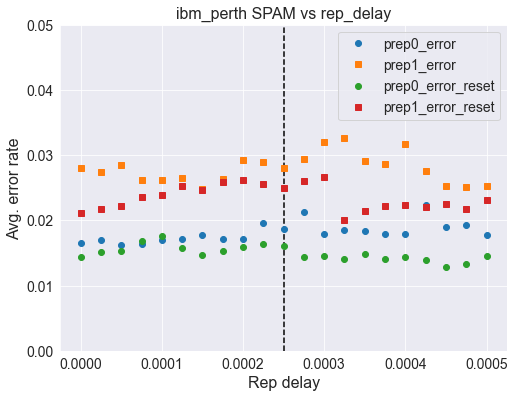

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axvline(default_rep_delay, color='k', linestyle='dashed')
ax.plot(rep_range, per_p0, 'o',label='prep0_error')
ax.plot(rep_range, per_p1, 's', label='prep1_error')
ax.plot(rep_range, per_p0_reset, 'o',label='prep0_error_reset')
ax.plot(rep_range, per_p1_reset, 's', label='prep1_error_reset')
ax.legend(fontsize=14)
ax.set_ylim([0,0.05])
ax.set_xlabel('Rep delay', fontsize=16)
ax.set_ylabel('Avg. error rate', fontsize=16)
ax.set_title('{} SPAM vs rep_delay'.format('ibm_perth'), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);